In [6]:
%load_ext autoreload
%autoreload 2


import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set(style="darkgrid")
import pandas as pd
np.set_printoptions(suppress=True)

import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
from utils import read_cleaned_ILI_tally

In [8]:
cleaned_ILI_tally_all = read_cleaned_ILI_tally()

Total rows = 2040316
Headers: ['Vendor', 'Source', 'Route', 'Route_NoPrefix', 'MP1', 'MP2', 'Year', 'ILI Project Name', 'ML Survey Date', 'Alignment Comment', 'Joint / US GW Number', 'ILI Survey Distance (ft)', 'Joint Length (ft)', 'From U/S GW (ft)', 'To D/S GW (ft)', 'Identification', 'Comment', 'Tool Speed (mph)', 'WT (in)', 'SMYS (PSI)', 'MAOP (PSI)', 'OD (in)', 'Longseam Visible', 'Seam Pos.', 'Depth (%)', 'Depth* (with tool tolerances)', 'OD Reduction (%)', 'Length (in)', 'Width (in)', "O'clock", 'Internal', 'Bend Radius (D)', 'Bend Angle (degrees)', 'Bend Direction', 'POF Category', 'Associated Tool Tolerance', 'Anomaly ID', 'Estimated Failure Pressure (Pf) ', 'Pf/MAOP', 'Pf* (with tool tolerances)', 'Pf*/MAOP', 'TotalBend Strain', 'Bend - Vert Strain Component', 'Bend - Horiz Strain Component', 'Internal Dent Strain', 'External Dent Strain', 'Easting', 'Northing', 'Latitude', 'Longitude', 'Elevation', 'U/S Reference', 'Dist. To U/S Ref [ft]', 'D/S Reference', 'Dist. To D/S Ref 

# Look at metal loss corrosion events

To determine wall loss due to corrosion, we look through the "Identification" field to eliminate all types other than "Manufacturing" related anomalies. The field corresponding to wall loss is "Depth (%)". So this is the one we care about.

The identification filtering step requires the following steps:

1. Convert to string
2. Remove all empty string/space
3. Remove all Identifications with "manufacturing" in it

**Update 11/1/2023**

Satvinder's compilation of ILI data informed me that the "Internal" column indicates whether an anomaly is internal or external. So add this criteria since we are only looking at external corrosion:

4. Include only rows that have "External" definition in the "Internal" column.
5. Use Satvinder's working definition "depth (%)" has to be greater than 0 to be counted.
6. "WT (in)", "OD" must all be present as well.

## Step 1: Remove all manufacturing related rows

In [9]:
from EC_corrosion_stats import filter_identifications

unique_identifications, ILI_with_cleaned_identifications = filter_identifications(cleaned_ILI_tally_all)

C:\Users\A1YU\OneDrive - PGE\Documents\code\ModelPerformance\EC_corrosion_stats.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_ILI_df["Identification"] = filtered_ILI_df["Identification"].astype(str).apply(lambda x: x.strip()).apply(lambda x: x.lower())


94.888% of all identifications has only 1 occurence


In [10]:
from EC_corrosion_stats import filter_manufacturing_anomalies

ILI_no_manufacturing_anomalies = filter_manufacturing_anomalies(ILI_with_cleaned_identifications)

Total 143920 manufacturing Identifications
Total 1734820 Identifications
 8.296% of identifications are manufacturing related
Total 1590900 non-manufacturing identifications


In [11]:
ILI_no_manufacturing_anomalies.columns

Index(['Vendor', 'Source', 'Route', 'Route_NoPrefix', 'MP1', 'MP2', 'Year',
       'ILI Project Name', 'ML Survey Date', 'Alignment Comment',
       'Joint / US GW Number', 'ILI Survey Distance (ft)', 'Joint Length (ft)',
       'From U/S GW (ft)', 'To D/S GW (ft)', 'Identification', 'Comment',
       'Tool Speed (mph)', 'WT (in)', 'SMYS (PSI)', 'MAOP (PSI)', 'OD (in)',
       'Longseam Visible', 'Seam Pos.', 'Depth (%)',
       'Depth* (with tool tolerances)', 'OD Reduction (%)', 'Length (in)',
       'Width (in)', 'O'clock', 'Internal', 'Bend Radius (D)',
       'Bend Angle (degrees)', 'Bend Direction', 'POF Category',
       'Associated Tool Tolerance', 'Anomaly ID',
       'Estimated Failure Pressure (Pf) ', 'Pf/MAOP',
       'Pf* (with tool tolerances)', 'Pf*/MAOP', 'TotalBend Strain',
       'Bend - Vert Strain Component', 'Bend - Horiz Strain Component',
       'Internal Dent Strain', 'External Dent Strain', 'Easting', 'Northing',
       'Latitude', 'Longitude', 'Elevation', 'U/

# Step 2: Mark which rows has volumetric loss

In [13]:
from EC_corrosion_stats import (
    get_volumetric_row_mask,
)

volumetric_row_mask = get_volumetric_row_mask(ILI_no_manufacturing_anomalies)
ILI_no_manufacturing_anomalies_augmented = ILI_no_manufacturing_anomalies.copy()
ILI_no_manufacturing_anomalies_augmented["volumetric_row_mask"] = volumetric_row_mask

In [14]:
np.sum(volumetric_row_mask)

261595

Only these many rows will be left, eventually. But before removing everything else, look at girth welds

In [135]:
for year in range(2001, 2024):
    num_EC_anomalies = np.sum(
        (ILI_no_manufacturing_anomalies_augmented["volumetric_row_mask"])
        & (ILI_no_manufacturing_anomalies_augmented["Year"] == year)
    )
    print(f"{year}: {num_EC_anomalies} EC anomalies available")

2001: 0 EC anomalies available
2002: 0 EC anomalies available
2003: 0 EC anomalies available
2004: 0 EC anomalies available
2005: 0 EC anomalies available
2006: 0 EC anomalies available
2007: 0 EC anomalies available
2008: 0 EC anomalies available
2009: 0 EC anomalies available
2010: 0 EC anomalies available
2011: 0 EC anomalies available
2012: 0 EC anomalies available
2013: 0 EC anomalies available
2014: 10 EC anomalies available
2015: 159 EC anomalies available
2016: 15937 EC anomalies available
2017: 31013 EC anomalies available
2018: 30226 EC anomalies available
2019: 37497 EC anomalies available
2020: 23021 EC anomalies available
2021: 62708 EC anomalies available
2022: 31295 EC anomalies available
2023: 29729 EC anomalies available


Also note, only 2014 and on have EC anomalies that can be used to calculate volumetric loss!

## Step 3: Aggregate anomalies by girth welds or pipe distance

In [15]:
from EC_corrosion_stats import (
    get_girth_weld_stats,
    GirthWeldStats,
)

(
    grouped_by_year_dict,
    grouped_by_year_by_route_dict, 
    list_dict_keys_with_girth_welds,
    girth_weld_stats,
) = get_girth_weld_stats(ILI_no_manufacturing_anomalies_augmented)

Year 2000, Route L-302E: No girth weld available, total survedy distance available=40.18
Year 2001, Route L-057B: No girth weld available, total survedy distance available=40.040000000000006
Year 2004, Route L-131: No girth weld available, total survedy distance available=137800.66999999998
Year 2005, Route L-172A: No girth weld available, total survedy distance available=157072.65
Year 2006, Route L-300B: No girth weld available, total survedy distance available=276397.525
Year 2007, Route L-021E: Average distance between girth welds is 43.335343676618585
Year 2007, Route L-153: No girth weld available, total survedy distance available=93777.292
Year 2009, Route L-119B: Average distance between girth welds is 32.809217522658614
Year 2011, Route L-177A: Average distance between girth welds is 41.824286626236834
Year 2011, Route L-210A: Average distance between girth welds is 36.07543587896254
Year 2012, Route L-1509-05: Average distance between girth welds is 36.91478260869566
Year 201

Roughly 20% of all survey routes don't have girth welds found...does this make sense?
- Looks like there are "seamless pipes",
- And also "welds" identifications -- should I treat "welds" the same as "girth welds"?
  - No, "welds" are different from girth welds

If it does, then need to just pick a distance number and aggregate!

In [22]:
# grouped_by_year_by_route_dict should have the same total rows as before..

assert np.sum(len(df) for df in grouped_by_year_dict.values()) == len(ILI_no_manufacturing_anomalies_augmented)

C:\Users\A1YU\AppData\Local\Temp\1\ipykernel_27200\4244548976.py:3: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  assert np.sum(len(df) for df in grouped_by_year_dict.values()) == len(ILI_no_manufacturing_anomalies_augmented)


In [23]:
assert np.sum([
    np.sum([len(df) for df in grouped_by_year_by_route_dict[year].values()])
    for year in grouped_by_year_by_route_dict.keys()
]) == len(ILI_no_manufacturing_anomalies_augmented)

### Segment by girth welds

Ignore routes without girth welds

In [24]:
from EC_corrosion_stats import (
    SegmentDescription,
    segment_route_by_girth_welds,
    segment_route_by_survey_dist,
)

In [25]:
dict_route_year_by_girth_weld = segment_route_by_girth_welds(grouped_by_year_by_route_dict, list_dict_keys_with_girth_welds)

In [28]:
# Stats to keep track of:
# 1. Total routes with girth welds
total_routes_with_girth_welds = len(list_dict_keys_with_girth_welds)
# 2. Total girth weld sections
total_girth_weld_sections = len(dict_route_year_by_girth_weld)
# 3. Girth weld sections with identifications that's not "girth weld" -- but can still contain other things
total_not_only_girth_weld_sections = np.sum([1 for (key, rows) in dict_route_year_by_girth_weld.items() if len(rows) > 1])

In [30]:
print(f"total routes with girth welds={total_routes_with_girth_welds}")
print(f"total girth weld sections={total_girth_weld_sections}")
print(f"total girth weld sections with other entries={total_not_only_girth_weld_sections}")

total routes with girth welds=185
total girth weld sections=672843
total girth weld sections with other entries=187136


### Segment by fixed distance

In [31]:
dict_year_route_seg_by_dist = segment_route_by_survey_dist(grouped_by_year_by_route_dict)

In [32]:
assert (
    np.sum(ILI_no_manufacturing_anomalies_augmented["ILI Survey Distance (ft)"].isna())
    + np.sum([len(df) for _, df in dict_year_route_seg_by_dist.items()])
) == len(ILI_no_manufacturing_anomalies_augmented)

In [33]:
# Stats to keep track of:
# 1. Total sections
total_distance_sections = len(dict_year_route_seg_by_dist)
# 2. Total distance sections with non-zero entries
non_empty_distance_sections = np.sum(len(rows) > 0 for (_, rows) in dict_year_route_seg_by_dist.items())

C:\Users\A1YU\AppData\Local\Temp\1\ipykernel_27200\939485008.py:5: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  non_empty_distance_sections = np.sum(len(rows) > 0 for (_, rows) in dict_year_route_seg_by_dist.items())


In [34]:
print(f"{total_distance_sections} total distance sections, {non_empty_distance_sections} are non-empty")

451761 total distance sections, 451761 are non-empty


There are more girth weld sections than distance sections because distance between girth welds are often less than 40ft!

# Step 3: Volumetric loss

We are interested to use the corrosion measurement to pin-point sections of pipes that require in-depth examination. Point-anomalies are too fine-grained, therefore aggregation by girth-weld or fixed-distance sections are in-order.

But the relative severity of the corrosion is dependent on pipe dimensions, therefore:
1. Use perc-depth corrosion to normalize against wall thickness: 10% of 100in thickness is 10 inch, but 50% of 5 inch thickness is 2.5 inch. The former is probably less severe than the latter, but 10 inch is 4x of 2.5 inch -- using absolute corrosion depth will mislead.
2. Width and length: is a 5x1 anomaly more severe than 1x5 anomaly? It again depends on the pipe dimensions -- for an 100in diameter pipe, both are probably equally insignificant.

To account for these, we will use perc-volumetric loss, defined as: `(total volume of metal loss) / (volume of the pipe segment)`. This is a good metric because:

1. Volume is normalized to total available volume, so outcome is normalized against different pipe dimensions.
2. Treat depth, width, and length equally -- a shallow corrosion that wraps around the entire pipe is just as severe as a thin, deep corrosion.

The volumetric loss is equal to:

$$v = \text{length} * \text{cross section area} $$

where `cross_section_area` is an annulus sector defined by the depth and width as the following:

$$\text{cross section area} = \frac{\theta}{2} (R^2 - r^2)$$
$$\theta = \text{width} / (\pi\text{OD})$$
$$R=\text{OD}/2$$
$$r=R - \text{depth}$$

The total pipe segment volume is equal to:

$$\pi h w_T (OD - w_T)$$

where $h$ is length of pipe segment, $w_T$ is the wall thickness. This is derived with the relationship between `OD` and `WT` as:

$$ OD - 2 W_T = \text{inner diameter}$$


In [90]:
from EC_corrosion_stats import (
    pipe_segment_volume,
    anomaly_volume,
    calculate_segment_frac_volumetric_loss,
    compile_volumetric_loss_for_all_segments,
)

### Calculate perc-volume loss per girth weld

In [65]:
result_per_girth_weld = compile_volumetric_loss_for_all_segments(
    dict_route_year_by_girth_weld,
    "girth weld",
)

2023-12-07 01:34:02,518 - INFO - Segment WT not uniform, taking average. WT_CV = 0.03329815473680036
2023-12-07 01:34:04,913 - INFO - Segment WT not uniform, taking average. WT_CV = 0.24350697100463894
2023-12-07 01:34:04,935 - INFO - Segment WT not uniform, taking average. WT_CV = 0.10375275938189842
2023-12-07 01:34:04,945 - INFO - Segment WT not uniform, taking average. WT_CV = 0.10375275938189842
2023-12-07 01:34:04,984 - INFO - Segment WT not uniform, taking average. WT_CV = 0.05498596005472208
2023-12-07 01:34:04,997 - INFO - Segment WT not uniform, taking average. WT_CV = 0.05613395702121124
2023-12-07 01:34:04,999 - INFO - Segment WT not uniform, taking average. WT_CV = 0.08542118358419432
2023-12-07 01:34:06,533 - INFO - Segment WT not uniform, taking average. WT_CV = 0.04648794375293087
2023-12-07 01:34:06,542 - INFO - Segment WT not uniform, taking average. WT_CV = 0.02449196672266251
2023-12-07 01:34:06,559 - INFO - Segment WT not uniform, taking average. WT_CV = 0.02479822

Looks like within girth-weld sections, WT doesn't differ by more than 10% most of the time, a few outliers, but should be ok

In [66]:
{key: np.sum(value[:, 0] != 0) for key, value in result_per_girth_weld.items()}

{2007: 0,
 2009: 0,
 2011: 0,
 2012: 0,
 2013: 0,
 2014: 0,
 2015: 0,
 2016: 2057,
 2017: 3451,
 2018: 4068,
 2019: 5405,
 2020: 3201,
 2021: 10036,
 2022: 5123,
 2023: 1463}

Looks like prior to 2007, we don't have any girth weld entries

### Calculate perc-volume loss per 40-ft segment

In [84]:
%pdb

Automatic pdb calling has been turned ON


In [91]:
result_per_segment = compile_volumetric_loss_for_all_segments(
    dict_year_route_seg_by_dist,
    "fixed distance",
    fixed_segment_length_ft=40.0,
)

2023-12-07 01:50:09,129 - INFO - Segment WT not uniform, taking average. WT_CV = 0.12830005981991682
2023-12-07 01:50:09,131 - INFO - Segment WT not uniform, taking average. WT_CV = 0.01969951813104459
2023-12-07 01:50:09,209 - INFO - Segment WT not uniform, taking average. WT_CV = 0.052276559865092706
2023-12-07 01:50:09,215 - INFO - Segment WT not uniform, taking average. WT_CV = 0.052276559865092706
2023-12-07 01:50:09,234 - INFO - Segment WT not uniform, taking average. WT_CV = 0.053990911863997515
2023-12-07 01:50:10,188 - INFO - Segment WT not uniform, taking average. WT_CV = 0.08939708939708942
2023-12-07 01:50:10,255 - INFO - Segment WT not uniform, taking average. WT_CV = 0.03329815473680036
2023-12-07 01:50:10,258 - INFO - Segment WT not uniform, taking average. WT_CV = 0.09152127821972215
2023-12-07 01:50:10,517 - INFO - Segment WT not uniform, taking average. WT_CV = 0.06372183202553193
2023-12-07 01:50:10,543 - INFO - Segment WT not uniform, taking average. WT_CV = 0.05705

For fixed distance pipe segments both WT and OD can be highly non-uniform. Use a cut-off for 10%.

# Step 4: Visualization

In [204]:
from EC_corrosion_stats import (
    plot_annual_frac_volumetric_loss,
    plot_distribution_and_sd,
    plot_all_frac_volumetric_loss,
)

In [221]:
fig_folder_path = "C:/Users/A1YU/OneDrive - PGE/Documents/code/ModelPerformance/EC_wall_loss_figs/"

## Girth weld statistics

C:\Users\A1YU\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\A1YU\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\A1YU\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\A1YU\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert in

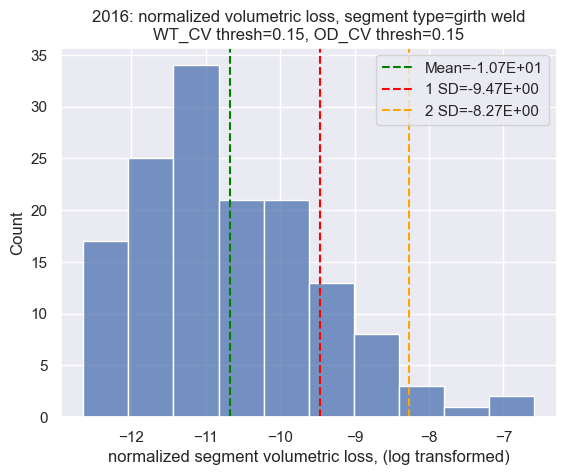

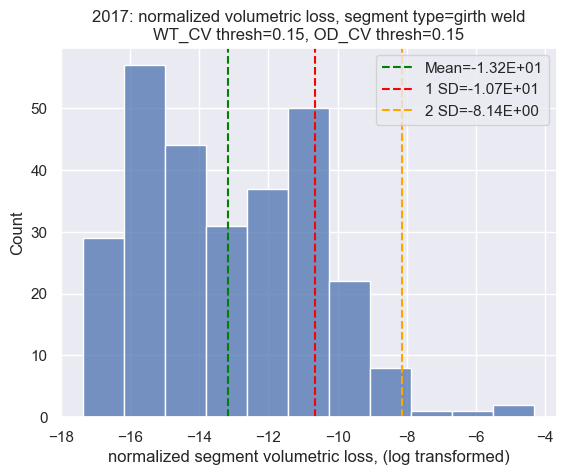

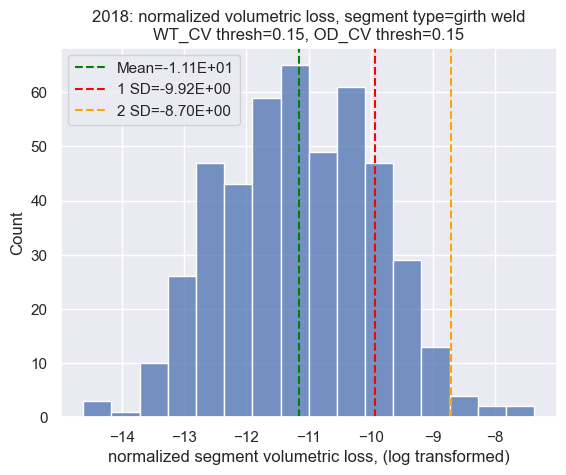

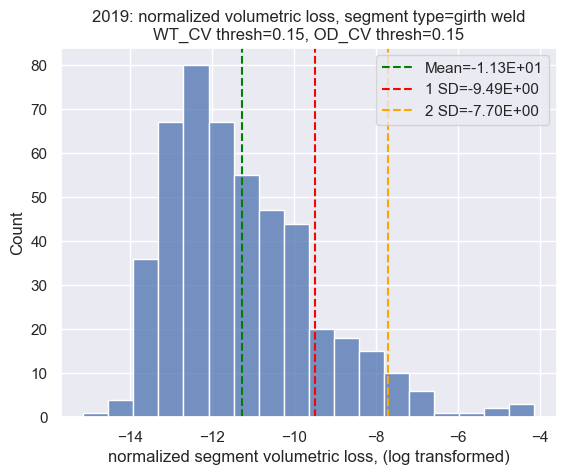

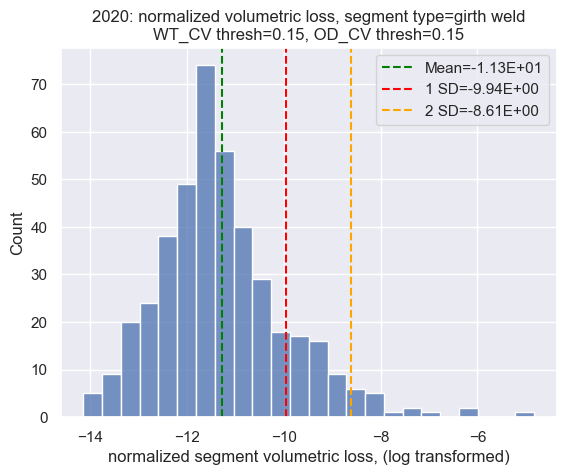

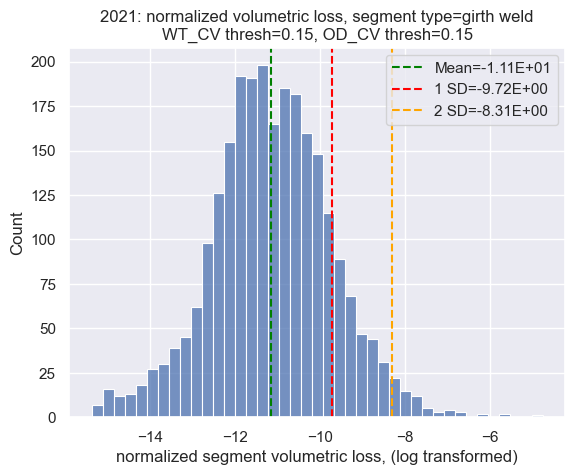

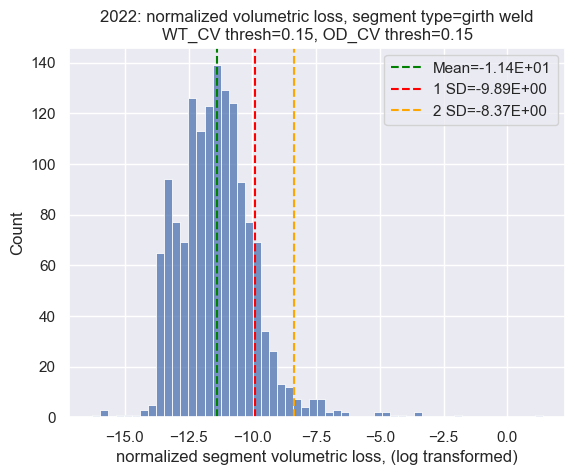

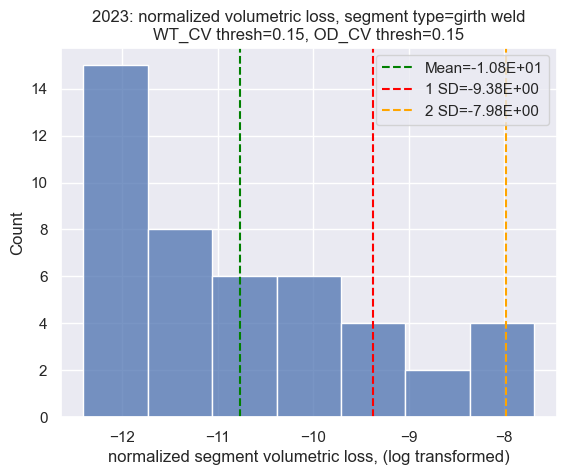

In [198]:
girth_weld_fig_list, girth_weld_stats_list = plot_annual_frac_volumetric_loss(
    result_per_girth_weld,
    segment_type="girth weld",
)

In [223]:
for (i, fig) in enumerate(girth_weld_fig_list):
    fig.savefig(fname=fr"{fig_folder_path}girth_weld_segments/annual_fig_{i}.png")

C:\Users\A1YU\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\A1YU\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


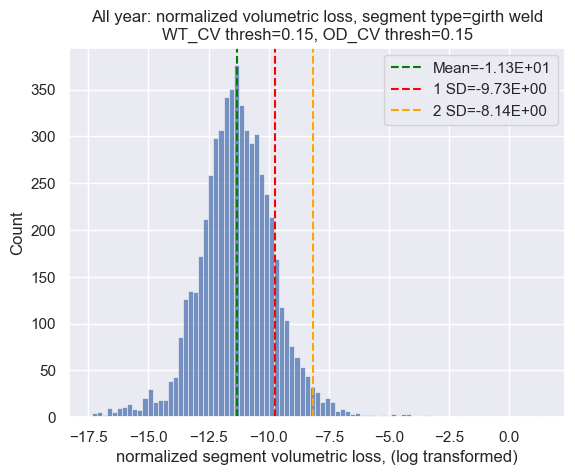

In [199]:
all_girth_weld_fig, all_girth_weld_stats = plot_all_frac_volumetric_loss(
    result_per_girth_weld,
    segment_type="girth weld",
)

In [222]:
all_girth_weld_fig.savefig(fname=fr"{fig_folder_path}girth_weld_segments/all_years.png")

In [194]:
np.exp(-8.14)

0.0002916371982355737

Note in all plots, the data values and x-axis are log transformed due to the skeweness of the distribution. Consequently, the mean and std are that of the LOG of the volumetric loss values.

This means to get the actual normalized segment volumetric loss, we need to take the exponent. So 2*SD value of -8.14 becomes $e^{-8.14} = 2.91\times 10^{-4}$.

## 40-ft segment statistics

C:\Users\A1YU\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\A1YU\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\A1YU\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\A1YU\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert in

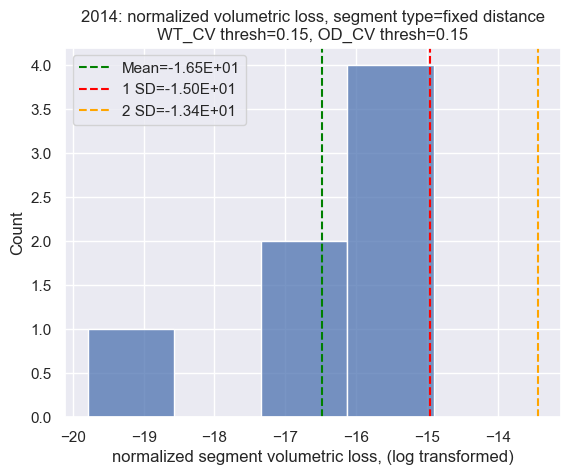

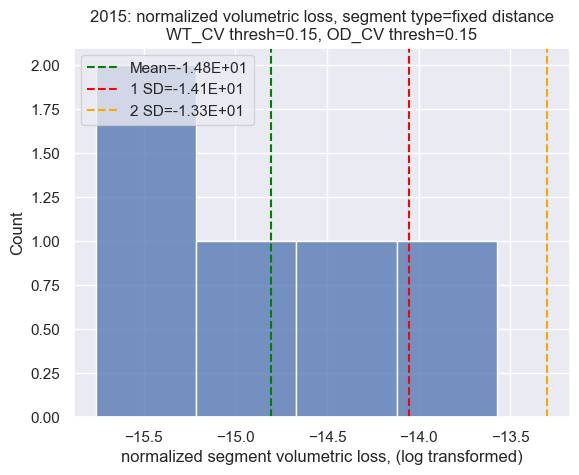

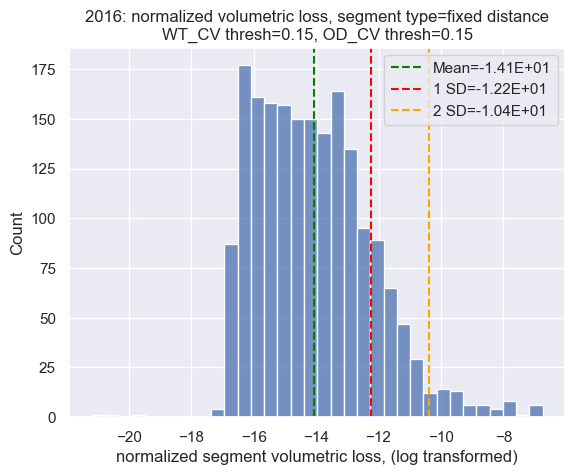

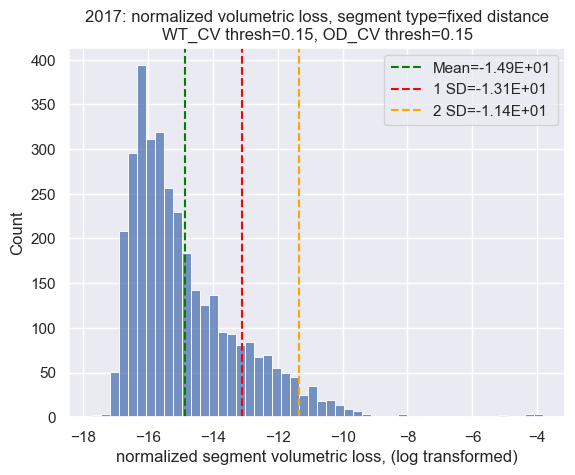

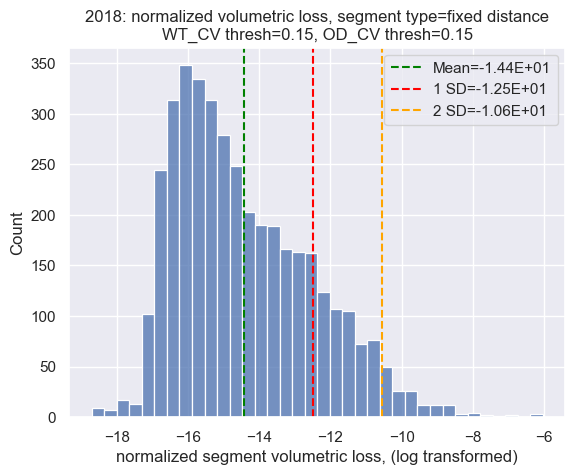

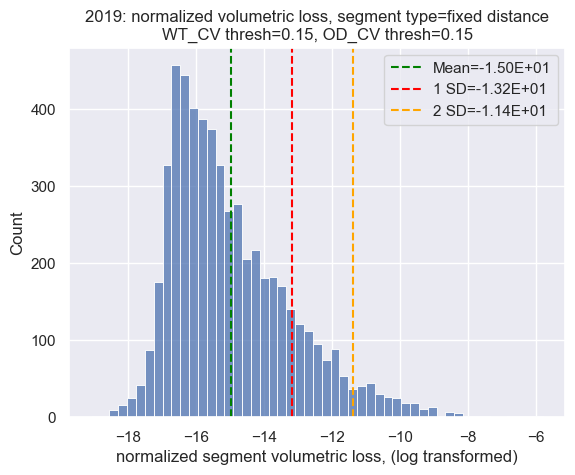

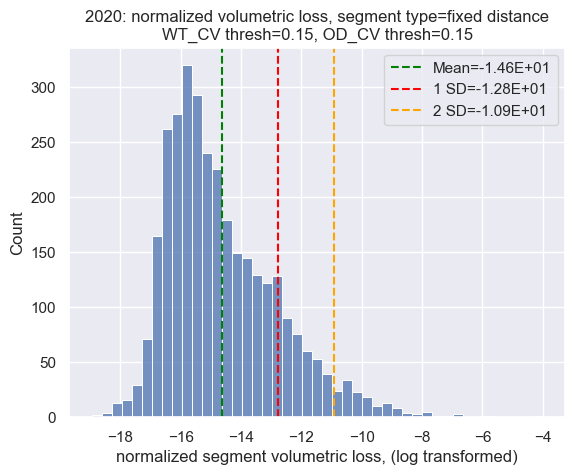

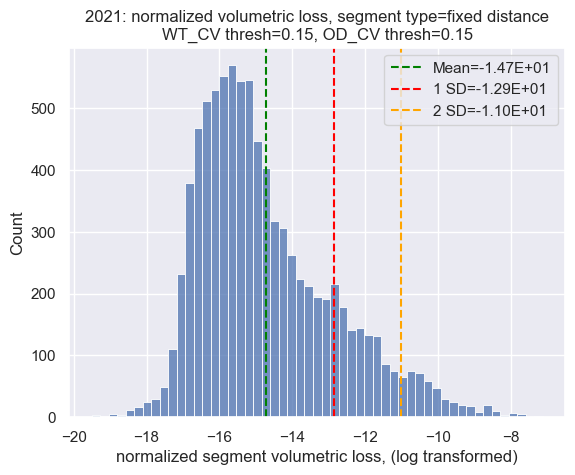

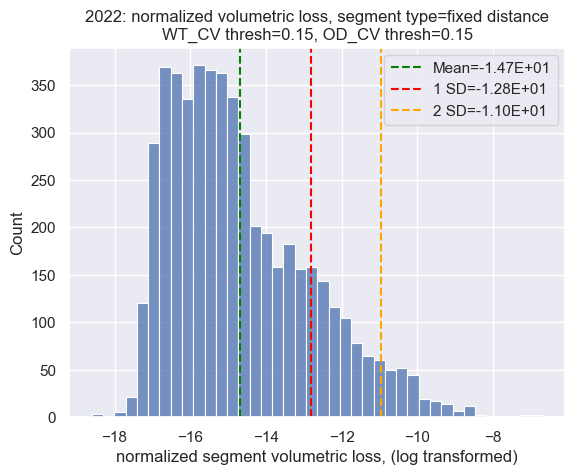

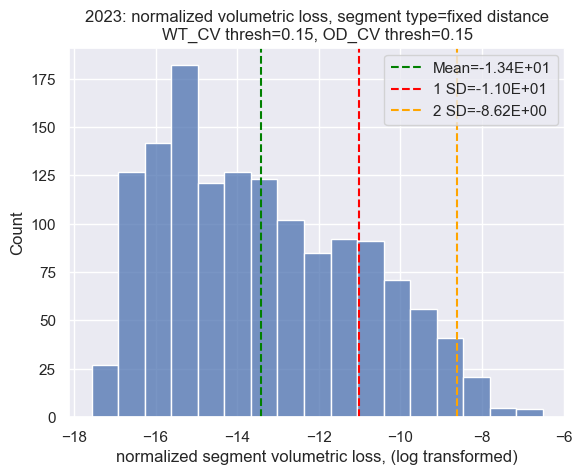

In [206]:
fixed_distance_fig_list, fixed_distance_stats_list = plot_annual_frac_volumetric_loss(
    result_per_segment,
    segment_type="fixed distance",
    fixed_segment_length_ft=40.0,
)

In [224]:
for (i, fig) in enumerate(fixed_distance_fig_list):
    fig.savefig(fname=fr"{fig_folder_path}fixed_distance_segments/40ft_segment_annual_fig_{i}.png")

C:\Users\A1YU\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\A1YU\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


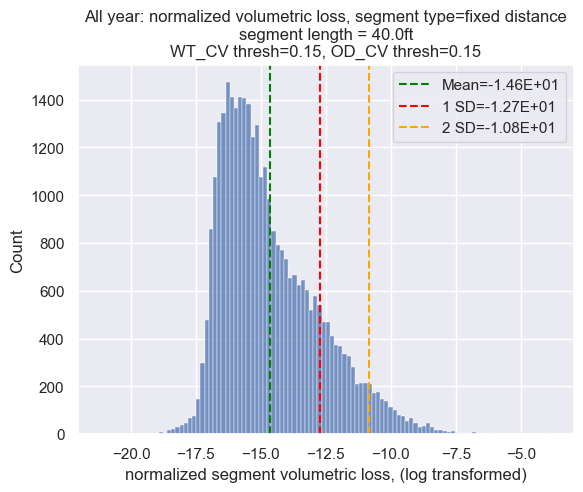

In [205]:
all_fixed_distance_fig, all_fixed_distance_stats = plot_all_frac_volumetric_loss(
    result_per_segment,
    segment_type="fixed distance",
    fixed_segment_length_ft=40.0,
)

In [225]:
all_fixed_distance_fig.savefig(fname=fr"{fig_folder_path}fixed_distance_segments/40ft_segment_all_years.png")

In [226]:
np.exp(-1.08e1)

2.0399503411171922e-05

For 40ft segment, the 2SD normalized volumetric loss is $2.04 \times 10^{-5}$. This makes sense, as the same amount of volumetric loss is a smaller proportion of a longer pipe segment.